# Testing networks with fast sign perturbated samples

Now that the networks have been trained, we are going to test them over perturbated samples. One of the most simple method to generate adversarial perturbations is the so called _Fast Sign Method_ presented in [1]. The idea is quite simple: Compute the gradient of the loss w.r.t. the input for a fixed input, and keep the sign of it:
$$
    x_{pert} = x + \epsilon sign(\nabla_x L(x,y,\theta))
$$

In what follows, we are going to test our previously trained network on such perturbated images for different values of $\epsilon$.

#### Bibliography
+ [1] Goodfellow, I. J., Shlens, J., & Szegedy, C. (2015). Explaining and Harnessing Adversarial Examples. Iclr 2015, 1–11.

## Experiments

In [1]:
import sys, os 
sys.path.append(os.getcwd()+'/../src')
sys.path.append(os.getcwd()+'/../data')

import numpy
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

import architectures
import cifar10
import utils
import perturbations

We import the data

In [2]:
X_test, y_test_lab = cifar10.load_cifar(dataset='testing', path=os.getcwd()+'/../data/cifar')
X_test = numpy.reshape(X_test, [X_test.shape[0], -1])
X_test = X_test/255.
X_test = X_test.astype(numpy.float32)
y_test = utils.labels_to_categoricals(y_test_lab)

We load networks

In [3]:
stab_net = architectures.CifarNet(path_to_logs=os.getcwd()+'/Logs')
stab_net.load('Networks/StabilityTrained')
class_net = architectures.CifarNet(path_to_logs=os.getcwd()+'/Logs')
class_net.load('Networks/ClassiclyTrained')

class_acc = class_net.test(X_test, y_test)
print("Classicly trained network accuracy: %f"%class_acc)
stab_acc = stab_net.test(X_test, y_test)
print("Stability trained network accuracy: %f"%stab_acc)

Classicly trained network accuracy: 0.783700
Stability trained network accuracy: 0.788100


## Gradient Computation 
We compute the gradient of the loss w.r.t. input for each input sample

In [6]:
stab_gradient = perturbations.compute_fs_grad_sym(stab_net, X_test, y_test)
numpy.save('stabgradient', stab_gradient)
class_gradient = perturbations.compute_fs_grad_sym(class_net, X_test, y_test)
numpy.save('classgradient', class_gradient)

In [4]:
stab_gradient = numpy.load('stabgradient.npy')
class_gradient = numpy.load('classgradient.npy')

How does perturbed images looks for $\epsilon=0.04$

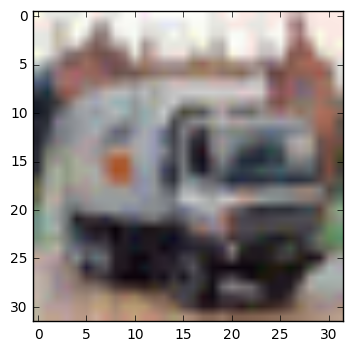

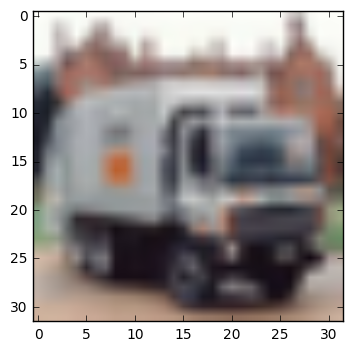

In [5]:
X_stab = X_test.copy() + 0.04*numpy.sign(stab_gradient)
X_stab /= X_stab.max()
i = 11
plt.imshow(numpy.reshape(X_stab[i], [32,32,3]))
plt.show()
plt.imshow(numpy.reshape(X_test[i], [32,32,3]))

## Accuracy Computation for fixed perturbation
We compute accuracy of each for $\epsilon=0.001$

In [6]:
eps = 0.001
X_stab = X_test.copy() + eps*numpy.sign(stab_gradient)
X_stab /= X_stab.max()
X_class = X_test.copy() + eps*numpy.sign(class_gradient)
X_class /= X_class.max()

In [7]:
class_acc = class_net.test(X_class, y_test)
print("Classicly trained network accuracy: %f"%class_acc)
stab_acc = stab_net.test(X_stab, y_test)
print("Stability trained network accuracy, for stabilized generated perturbations: %f"%stab_acc)
stab_acc = stab_net.test(X_class, y_test)
print("Stability trained network accuracy, for classic generated perturbations: %f"%stab_acc)

Classicly trained network accuracy: 0.754600
Stability trained network accuracy, for stabilized generated perturbations: 0.757700
Stability trained network accuracy, for classic generated perturbations: 0.771200


## Accuracy curve for varying $\epsilon$
We compute accuracies for different values of $\epsilon$

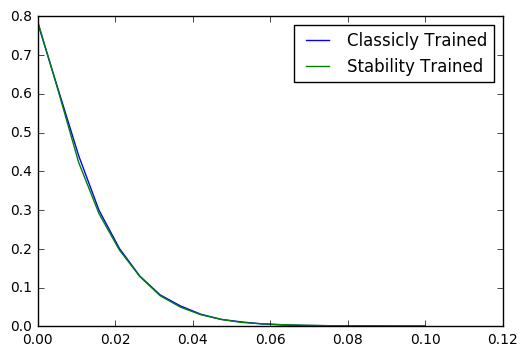

In [12]:
epsilons = numpy.linspace(0.0001, 0.1, 20)
accuracies = numpy.zeros([2,epsilons.shape[0]])
for epsiter in range(0,epsilons.shape[0]):
    X_stab = X_test.copy() + epsilons[epsiter]*numpy.sign(stab_gradient)
    X_stab /= X_stab.max()
    X_class = X_test.copy() + epsilons[epsiter]*numpy.sign(class_gradient)
    X_class /= X_class.max()
    accuracies[0,epsiter] = class_net.test(X_class, y_test)
    accuracies[1,epsiter] = stab_net.test(X_stab, y_test)
plt.plot(epsilons,accuracies[0], label='Classicly Trained')
plt.plot(epsilons,accuracies[1], label='Stability Trained')
plt.legend()
plt.savefig('Figures/accuracy_curv.pdf')

## Precision-Recall Curve for fixed $\epsilon$
We compute the precision recall curve using the __top-n__ accuracy for $n\in [1,10]$

CPU times: user 3min 10s, sys: 38.7 s, total: 3min 49s
Wall time: 2min 29s


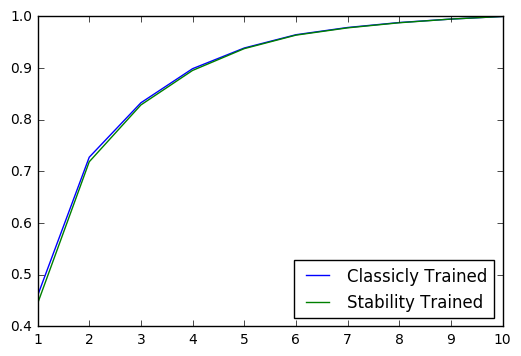

In [20]:
%%time
top_ns = numpy.arange(1,11)
accuracies = numpy.zeros([2, top_ns.shape[0]])
eps = 0.01
X_stab = X_test.copy() + eps*numpy.sign(stab_gradient)
X_stab /= X_stab.max()
X_class = X_test.copy() + eps*numpy.sign(class_gradient)
X_class /= X_class.max()

for itr in range(0,top_ns.shape[0]):
    accuracies[0,itr] = class_net.test(X_class, y_test, top=top_ns[itr])
    accuracies[1,itr] = stab_net.test(X_stab, y_test, top=top_ns[itr])
    
plt.plot(top_ns,accuracies[0], label='Classicly Trained')
plt.plot(top_ns,accuracies[1], label='Stability Trained')
plt.legend(loc=4)
plt.savefig('Figures/precision_recall.pdf')

## Automatic Experiments

Here, we launch a bunch of experiments to make automatically 

In [4]:
blank_net = architectures.CifarNet(path_to_logs=os.getcwd()+'/Logs')
blank_net.load('Networks/BlankNet')
if True:
    blank_gradient = perturbations.compute_fs_grad_sym(blank_net, X_test, y_test)
    numpy.save('blankgradient', blank_gradient)
else:
    blank_gradient = numpy.load('blankgradient.npy')

In [5]:
class_net = architectures.CifarNet(path_to_logs=os.getcwd()+'/Logs')
class_net.load('Networks/ClassiclyTrained')
if True:
    class_gradient = perturbations.compute_fs_grad_sym(class_net, X_test, y_test)
    numpy.save('classgradient', class_gradient)
else:
    class_gradient = numpy.load('classgradient.npy')

In [6]:
stab_nets_name = ['Networks/StabilityTrained1', 'Networks/StabilityTrained2', 'Networks/StabilityTrained3']
pre_rec_values = [0, 0.01, 0.03, 0.1]

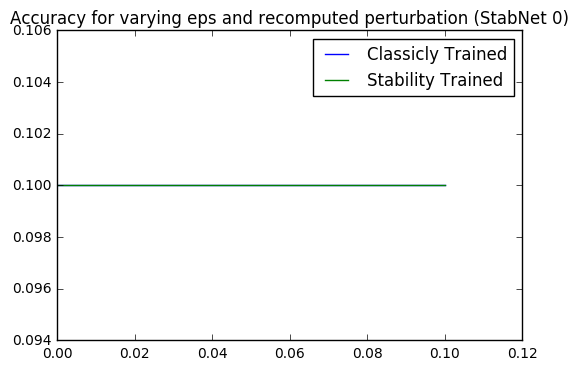

KeyboardInterrupt: 

In [7]:
for net_iter in range(0,3):
    stab_net = architectures.CifarNet(path_to_logs=os.getcwd()+'/Logs')
    stab_net.load(stab_nets_name[net_iter])
    stab_gradient = perturbations.compute_fs_grad_sym(stab_net, X_test, y_test)
    numpy.save('stabgradient'+str(net_iter), stab_gradient)
    
    ## Experiment1: Accuracy curve for recomputed perturbation
    epsilons = numpy.linspace(0.0001, 0.1, 20)
    accuracies = numpy.zeros([2,epsilons.shape[0]])
    for epsiter in range(0,epsilons.shape[0]):
        X_stab = X_test.copy() + epsilons[epsiter]*numpy.sign(stab_gradient)
        X_stab /= X_stab.max()
        X_class = X_test.copy() + epsilons[epsiter]*numpy.sign(class_gradient)
        X_class /= X_class.max()
        accuracies[0,epsiter] = class_net.test(X_class, y_test)
        accuracies[1,epsiter] = stab_net.test(X_stab, y_test)
    plt.plot(epsilons,accuracies[0], label='Classicly Trained')
    plt.plot(epsilons,accuracies[1], label='Stability Trained')
    plt.title("Accuracy for varying eps and recomputed perturbation (StabNet %i)"%net_iter)
    plt.legend()
    plt.savefig('Figures/exp%i-1.pdf'%net_iter)
    plt.show()

    ## Experiment2: Accuracy curve for blank perturbation
    epsilons = numpy.linspace(0.0001, 0.1, 20)
    accuracies = numpy.zeros([2,epsilons.shape[0]])
    for epsiter in range(0,epsilons.shape[0]):
        X = X_test.copy() + epsilons[epsiter]*numpy.sign(blank_gradient)
        X /= X.max()
        accuracies[0,epsiter] = class_net.test(X, y_test)
        accuracies[1,epsiter] = stab_net.test(X, y_test)
    plt.plot(epsilons,accuracies[0], label='Classicly Trained')
    plt.plot(epsilons,accuracies[1], label='Stability Trained')
    plt.title("Accuracy for varying eps and blank perturbation (StabNet %i)"%net_iter)
    plt.legend()
    plt.savefig('Figures/exp%i-2.pdf'%net_iter)
    plt.show()
    
     ## Experiment3: Precision Recall curves for recomputed perturbations
    for pr_iter in range(0,4):
        top_ns = numpy.arange(1,11)
        accuracies = numpy.zeros([2, top_ns.shape[0]])
        eps = pre_rec_values[pr_iter]
        X_stab = X_test.copy() + eps*numpy.sign(stab_gradient)
        X_stab /= X_stab.max()
        X_class = X_test.copy() + eps*numpy.sign(class_gradient)
        X_class /= X_class.max()
        for itr in range(0,top_ns.shape[0]):
            accuracies[0,itr] = class_net.test(X_class, y_test, top=top_ns[itr])
            accuracies[1,itr] = stab_net.test(X_stab, y_test, top=top_ns[itr])
        plt.plot(top_ns,accuracies[0], label='Classicly Trained')
        plt.plot(top_ns,accuracies[1], label='Stability Trained')
        plt.title("Precision-Recall for eps=%f with recomputed perturbation (StabNet %i)"%(eps, i))
        plt.legend(loc=4)
        plt.savefig('Figures/exp%i-3-%i.pdf'%(net_iter, pr_iter))
        plt.show()
        
    ## Experiment4: Precision Recall curves for blank perturbation
    for pr_iter in range(0,4):
        top_ns = numpy.arange(1,11)
        accuracies = numpy.zeros([2, top_ns.shape[0]])
        eps = pre_rec_values[pr_iter]
        X = X_test.copy() + eps*numpy.sign(blank_gradient)
        X /= X.max()
        for itr in range(0,top_ns.shape[0]):
            accuracies[0,itr] = class_net.test(X, y_test, top=top_ns[itr])
            accuracies[1,itr] = stab_net.test(X, y_test, top=top_ns[itr])
        plt.plot(top_ns,accuracies[0], label='Classicly Trained')
        plt.plot(top_ns,accuracies[1], label='Stability Trained')
        plt.title("Precision-Recall for eps=%f with blank perturbation (StabNet %i)"%(eps, i))
        plt.legend(loc=4)
        plt.savefig('Figures/exp%i-4-%i.pdf'%(net_iter, pr_iter))
        plt.show()
